In [ ]:
!pip install basemap
!pip install -U kaleido
!pip install fiona
!pip install igraph

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import os
from mpl_toolkits.basemap import Basemap
from mpl_toolkits.basemap import shiftgrid
from osgeo import gdal
import numpy as np
from sklearn.metrics.cluster import normalized_mutual_info_score
import seaborn as sns
import plotly.figure_factory as ff
from scipy.spatial.distance import pdist, squareform
import plotly.io as pio
import fiona
import geopandas as gpd

In [ ]:
detections = pd.read_csv('/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Data/Bull_detections.csv')

In [ ]:
# Convert the Localtime column to datetime
detections['Localtime'] = pd.to_datetime(detections['Localtime'], dayfirst=True)

In [ ]:
detections.sort_values(by='Localtime', ascending=True, inplace=True)
detections.head(4)

,Localtime,Shark,SharkTypeGender,Station,Hour
0,2018-12-08 02:05:00,B02F,Bull_F,H4,2
1,2018-12-08 02:06:00,B02F,Bull_F,H4,2
2,2018-12-08 02:12:00,B02F,Bull_F,H3,2
3,2018-12-08 02:12:00,B02F,Bull_F,H3,2


In [ ]:
df_sharks = pd.read_csv(r'/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Data/sharks.csv')
df_stations = pd.read_csv(r'/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Data/stations.csv')

In [ ]:
Bull_mask = df_sharks['Specie'] == 'Bull'
df_sharks = df_sharks[Bull_mask]

path = r'/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Bull'
os.chdir(path)

In [ ]:
Sharks = sorted(df_sharks['Shark'].unique())
Stations = sorted(df_stations['Station'].unique())

In [ ]:
Sharks_labels = {node: node for node in Sharks}
Stations_labels = {node: node for node in Stations}

In [ ]:
h=12
#defining the hour
hour_mask = detections['Hour'] == h
hour_detections = detections[hour_mask]
h_detections = hour_detections.groupby(['Shark','Station']).size().reset_index(name='num_detections')


###################################################################################################################################################################
##############################################  create a bipartite graph #############################################
B = nx.Graph()
# Add shark nodes with positions
for index, row in df_sharks.iterrows():
    B.add_node(row['Shark'], bipartite=0, pos=(row['Longitude'], row['Latitude']))

# Add station nodes with positions
for index, row in df_stations.iterrows():
    B.add_node(row['Station'], bipartite=1, pos=(row['Longitude'], row['Latitude']))

# Add edges and weights
for i, row in h_detections.iterrows():
    B.add_edge(row['Shark'], row['Station'], weight=row['num_detections'])




df_shark = df_sharks[['Shark', 'Latitude', 'Longitude']]
df_station = df_stations[['Station', 'Latitude', 'Longitude']]

df_shark.rename(columns={"Shark":"Label"},inplace=True)
df_station.rename(columns={"Station":"Label"},inplace=True)

df_sharks_stations = pd.concat([df_shark,df_station], ignore_index=True)
######################################################################################################################################################################################
# Drawing the networks
# Adjusting the map resolution to 'intermediate'
fig, ax = plt.subplots(figsize=(29,20))
m = Basemap(projection='tmerc', lat_0 = df_sharks_stations['Latitude'].mean(), lon_0 = df_sharks_stations['Longitude'].mean(),
            llcrnrlon=166.2700, llcrnrlat=-22.3500,
            urcrnrlon=166.4900, urcrnrlat=-22.2100,  resolution='i', ax=ax)


# Load the orthophoto
image = plt.imread('/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Data/ground.jpg')

image_flipped = np.flipud(image)
m.imshow(image_flipped)



mx, my = m( df_sharks_stations['Longitude'].values,  df_sharks_stations['Latitude'].values)
pos = {}
for count, elem in enumerate ( df_sharks_stations['Label']):
    pos[elem] = (mx[count], my[count])

area_names = df_stations['Area'].unique()

# Generate a list of distinct colors for the 11 areas
# Using a color palette that provides good distinction between colors
color_palette = px.colors.qualitative.G10  # This palette has distinct colors

color_palette[6]='#FF6692'
color_palette[7]='#5ad166'
color_palette[8]='#8c564b'
color_palette[9]='#9467bd'
color_palette.append('#FFD700')
# Create a dictionary mapping each area to a color from the palette
color_scale = {area: color_palette[i] for i, area in enumerate(area_names)}



# Draw nodes
for node in Stations:
    area = df_stations[df_stations['Station'] == node]['Area'].values[0]
    color = color_scale[area]
    nx.draw_networkx_nodes(B, pos, nodelist=[node], node_color=color, node_size=[2000], node_shape='o', edgecolors=['k'])

pos_higher = {}

for k, v in pos.items():
    if(v[1]>0):
        pos_higher[k] = (v[0], v[1])
    else:
        pos_higher[k] = (v[0], v[1])

Stations_lab = {node: node.split('_')[0] for node in Stations}
#bbox = dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3')
# Draw networkx labels with vertical alignment adjusted using bbox
for node, (x, y) in pos_higher.items():
    if node in Sharks_labels.keys():
        pass
    else:

        plt.text(x, y, Stations_lab[node], fontsize=20, color='k', ha='center', va='center')



# Show plot
plt.tight_layout()
plt.grid(True)
# Save the plot as a JPG file
name ='studyarea.png'
plt.savefig(name)
plt.close()

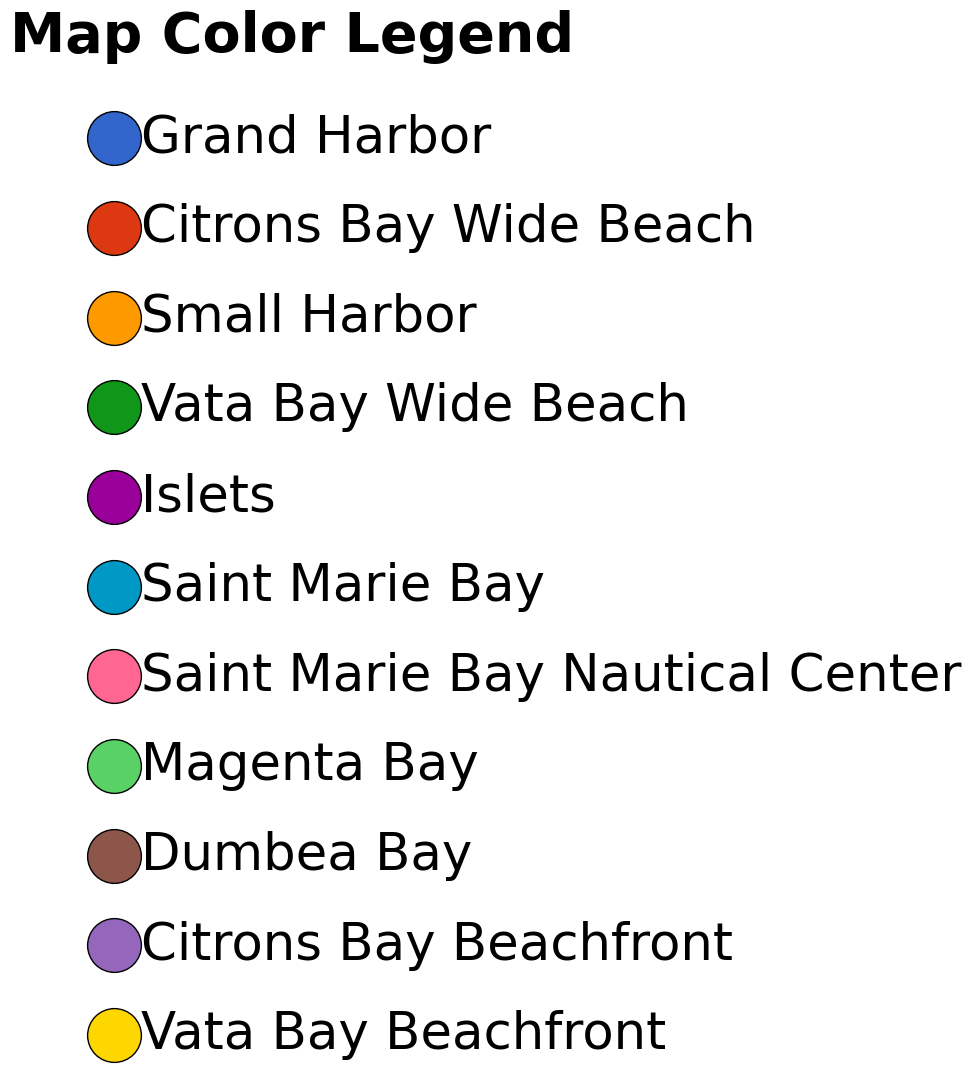

In [ ]:
# Settings
font_size = 37
circle_size = 1500  # Marker size
spacing_y = 0.3
columns = 1

# Calculate layout
items = list(color_scale.items())
rows = (len(items) + columns - 1) // columns

fig, ax = plt.subplots(figsize=(8, rows))  # Adjust height to number of rows
ax.axis('off')  # No axis

# Plot circles and labels
for i, (label, color) in enumerate(items):
    #col = i // rows
    row = i % rows
    x = 0
    y = -row * spacing_y

    ax.scatter(x, y, s=circle_size, color=color, edgecolors='black')
    ax.text(x + 0.025, y, label, va='center', ha='left', fontsize=font_size)

# Add title
plt.title("Map Color Legend", fontsize=40, weight='bold', pad=30, x=2)

# Fit layout
plt.tight_layout()
plt.show()
plt.close()

In [ ]:
def build_intervals_from_weights(edge_weights):
    s = pd.Series(edge_weights)
    percentiles = [0, 25, 50, 75, 90, 95, 99, 100]
    boundaries = list(np.percentile(s, percentiles))
    intervals = []

    for i in range(len(boundaries)-1):
        start = int(np.floor(boundaries[i]))
        end = int(np.ceil(boundaries[i+1]))
        intervals.append((start, end))

    return intervals

def adjust_edge_weights(edge_weights):
    intervals = build_intervals_from_weights(edge_weights)
    weights = [i + 0.5 for i in range(len(intervals))]

    new_edge_weights = []

    for weight in edge_weights:
        new_weight = weight  # fallback
        for i, (start, end) in enumerate(intervals):
            if start <= weight <= end:
                new_weight = weights[i]
                break
        new_edge_weights.append(new_weight)

    return new_edge_weights

In [ ]:
# === Legend Drawing Functions ===
from matplotlib.patches import Ellipse, Polygon

def draw_diamond_legend(ax, center, size, transform, color='red'):
    x, y = center
    half = size / 2.25
    points = [
        (x, y + half + half / 4),
        (x + half, y),
        (x, y - (half + half / 4)),
        (x - half, y)
    ]
    diamond = Polygon(points, closed=True, color=color, ec='black', transform=transform, clip_on=False)
    ax.figure.add_artist(diamond)

def draw_node_size_legend(ax, shark_degrees, shark_sizes, station_degrees, station_sizes, base_y=0.775, start_x=0.03, max_x=0.3):
    trans = ax.figure.transFigure  # Use figure coordinate system

    # Determine the number of items to lay out evenly
    max_items = max(len(shark_degrees), len(station_degrees))
    total_width = max_x - start_x
    step = total_width / (max_items - 1) if max_items > 1 else 0

    # === Shark nodes: red diamonds ===
    for i, (degree, size) in enumerate(zip(shark_degrees, shark_sizes)):
        x = start_x + i * step
        y = base_y + 0.0655
        size_scaled = 0.035 * size  # Adjust size for figure scale
        draw_diamond_legend(ax, (x, y - 0.0025), size_scaled, trans)
        ax.figure.text(x, y + 0.01825, f"{degree}", ha='center', va='bottom', fontsize=24, transform=trans)

    ax.figure.text(start_x, base_y + 0.11, "Shark Degree", fontsize=35, weight='bold', transform=trans)

    # === Station nodes: green circles ===
    for i, (degree, size) in enumerate(zip(station_degrees, station_sizes)):
        x = start_x + i * step
        y = base_y - 0.02
        radius = 0.018 * size
        ellipse = Ellipse((x, y - 0.0025), width=radius * 2.2, height=radius * 3,
                          color='green', ec='black', transform=trans, clip_on=False)
        ax.figure.add_artist(ellipse)
        ax.figure.text(x, y + 0.016, f"{degree}", ha='center', va='bottom', fontsize=24, transform=trans)

    ax.figure.text(start_x, base_y + 0.0225, "Station Degree", fontsize=35, weight='bold', transform=trans)



def draw_edge_weight_legend(fig, edge_intervals, edge_widths, base_y=0.67, start_x=0.03):
    for i, ((start, end), width) in enumerate(zip(edge_intervals, edge_widths)):
        y = base_y - i * 0.025
        fig.lines.append(plt.Line2D([start_x, start_x + 0.09], [y, y], transform=fig.transFigure,
                                    color='black', linewidth=width * 1))
        fig.text(start_x + 0.095, y, f"[{start}-{end}]", va='center', fontsize=24)
    fig.text(start_x, base_y + 0.02, "Edge Weights", fontsize=35, weight='bold')

In [ ]:
def normalize_sizes(degrees, min_size=0.15, max_size=0.7):
    d_min = min(degrees)
    d_max = max(degrees)
    return [
        round(min_size + ((deg - d_min) / (d_max - d_min)) * (max_size - min_size), 3)
        if d_max != d_min else round((min_size + max_size) / 2, 3)  # handle case when all degrees are equal
        for deg in degrees
    ]

In [ ]:
# === MAIN HOURLY LOOP ===
for h in range(0,24):
    hour_detections = detections[detections['Hour'] == h]
    h_detections = hour_detections.groupby(['Shark', 'Station']).size().reset_index(name='num_detections')

    B = nx.Graph()

    # Add nodes
    for _, row in df_sharks.iterrows():
        B.add_node(row['Shark'], bipartite=0, pos=(row['Longitude'], row['Latitude']))
    for _, row in df_stations.iterrows():
        B.add_node(row['Station'], bipartite=1, pos=(row['Longitude'], row['Latitude']))
    for _, row in h_detections.iterrows():
        B.add_edge(row['Shark'], row['Station'], weight=row['num_detections'])

    # Get edge weights and intervals
    edge_weights = [B[u][v]['weight'] for u, v in B.edges()]
    edge_intervals = build_intervals_from_weights(edge_weights)
    new_edge_weights = adjust_edge_weights(edge_weights)

    # Start plot
    fig, ax = plt.subplots(figsize=(29, 20))
    m = Basemap(projection='tmerc',
                lat_0=df_sharks['Latitude'].mean(),
                lon_0=df_sharks['Longitude'].mean(),
                llcrnrlon=166.2700, llcrnrlat=-22.3500,
                urcrnrlon=166.4900, urcrnrlat=-22.2100,
                resolution='i', ax=ax)

    image = plt.imread('/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Data/ground.jpg')
    m.imshow(np.flipud(image))

    # Prepare node positions
    df_all = pd.concat([
        df_sharks.rename(columns={"Shark": "Label"}),
        df_stations.rename(columns={"Station": "Label"})
    ])
    mx, my = m(df_all['Longitude'].values, df_all['Latitude'].values)
    pos = {label: (mx[i], my[i]) for i, label in enumerate(df_all['Label'])}

    node_degree = dict(B.degree())

    # Node size legend
    shark_degrees = sorted(set([node_degree[n] for n in Sharks if n in node_degree]))
    station_degrees = sorted(set([node_degree[n] for n in Stations if n in node_degree]))

    shark_sizes = normalize_sizes(shark_degrees, 0.25, 1.25)
    station_sizes = normalize_sizes(station_degrees, 0.15, 0.725)



    Sharks = df_sharks['Shark'].tolist()
    Stations = df_stations['Station'].tolist()

    # Draw nodes
    nx.draw_networkx_nodes(B, pos, nodelist=Sharks,
                          node_color='red', node_shape='D', edgecolors='k',
                          node_size=[(((1 + node_degree[n] -  min(shark_degrees)) / ( max(shark_degrees) -  min(shark_degrees))) * 3500) for n in Sharks])
    nx.draw_networkx_nodes(B, pos, nodelist=Stations,
                          node_color='green', node_shape='o', edgecolors='k',
                          node_size=[((1 + node_degree[n] - min(station_degrees)) / (max(station_degrees) - min(station_degrees))) * 3000 for n in Stations])

    # Labels (if dictionaries provided)
    for node, (x, y) in pos.items():
        if node in Sharks_labels:
            plt.text(x, y, Sharks_labels[node],
                    fontsize=25 * ((1 + node_degree[node] - min(shark_degrees)) / (max(shark_degrees) - min(shark_degrees))), ha='center', va='center')
        elif node in Stations_labels:
            plt.text(x, y, Stations_labels[node],
                    fontsize=25 * ((1 + node_degree[node] - min(station_degrees)) / (max(station_degrees) - min(station_degrees))), ha='center', va='center')

    # Draw edges
    nx.draw_networkx_edges(B, pos, width=new_edge_weights, edge_color='k')

    # Hour title
    plt.text(0.03, 0.975, f'{h} h', transform=ax.transAxes,
            fontsize=60, verticalalignment='top',
            bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))

    # Edge weight legend
    edge_legend_widths = [w for i, w in enumerate(set(new_edge_weights))]
    edge_legend_intervals = edge_intervals[:len(edge_legend_widths)]  # Match order
    draw_edge_weight_legend(fig, edge_legend_intervals, edge_legend_widths)

    draw_node_size_legend(ax, shark_degrees, shark_sizes, station_degrees, station_sizes)

    # Save
    plt.tight_layout()
    plt.savefig(f'Bull_{h}_network.png')
    plt.show()
    plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
column_names = [
    'Network hour',
    "Network density",
    "Number of edges",
    "Modularity of FG",
    "Number of detected communities by FG",
    'Number of isolated_sharks by FG',
    'Number of isolated_stations by FG',
    'Number of Communities (Shs & Sts) by FG',
    "Number of single community by FG",
    "Modularity of LP",
    "Number of detected communities by LP",
    "Modularity of LV",
    "Number of detected communities by LV"
]
Results = pd.DataFrame(index=range(24),columns=column_names)

In [ ]:
FG = {}

In [ ]:
df_shark = df_sharks[['Shark', 'Latitude', 'Longitude']]
df_station = df_stations[['Station', 'Latitude', 'Longitude']]

df_shark.rename(columns={"Shark":"Label"},inplace=True)
df_station.rename(columns={"Station":"Label"},inplace=True)

sharks_stations = pd.concat([df_shark,df_station], ignore_index=True)

In [ ]:
# tag_color_index_h=17
tag_color_index_2 = { 'SM6': ('#00CC96', 1),  'H2': ('#AB63FA', 2)}

# tag_color_index_3
h_3_H1 = [1, 2,  3,  6, 7, 8, 9, 10, 11, 12, 13, 16]
h_3_23 = [ 18, 19, 22]
tag_color_index_3_H1 = { 'SM6': ('#00CC96', 1),  'H2': ('#AB63FA', 2), 'H1': ('#19D3F3', 3) }
tag_color_index_3_23 = { 'SM6': ('#00CC96', 1),  'H2': ('#AB63FA', 2), 'B14M': ('#19D3F3', 3) }


# tag_color_index_4
h_4_30= [0, 4, 5, 15]
h_4_23 = [ 14, 20, 21, 23]
tag_color_index_4_30 = { 'SM6': ('#00CC96', 1),  'H2': ('#AB63FA', 2), 'H1': ('#19D3F3', 3), 'B18M': ('#A65628', 4) }
tag_color_index_4_23 = { 'SM6': ('#00CC96', 1),  'H2': ('#AB63FA', 2), 'H1': ('#19D3F3', 3),  'B14M': ('#A65628', 4) }


def assertion_index_color(h,sharks_stations, conditions, n, dict_communities):
    color_community, found_index = [], []
    for elem in sharks_stations['Label']:
        co, ind = None, None
        for sublst in dict_communities['FastGreedy']:
            if sublst is not None:
                  if elem in sublst:
                      if len(sublst) == 1:
                          #co, ind = '#FFD700', n
                          break
                      else:
                          for cond, (color, index) in conditions.items():
                              if cond in sublst:
                                  co, ind = color, index
                                  break

        color_community.append(co)
        found_index.append(ind)


    hr =  str(h)+'_community'
    hrcolor = str(h)+'_Color'

    sharks_stations[hr] = found_index
    sharks_stations[hrcolor] = color_community

    return sharks_stations



In [ ]:
for h in range(0,24):
    #defining the hour
    hour_mask = detections['Hour'] == h
    hour_detections = detections[hour_mask]
    h_detections = hour_detections.groupby(['Shark','Station']).size().reset_index(name='num_detections')

    ###################################################################################################################################################################
    ##############################################  create a bipartite graph #############################################
    B = nx.Graph()
    # Add shark nodes with positions
    for index, row in df_sharks.iterrows():
        B.add_node(row['Shark'], bipartite=0, pos=(row['Longitude'], row['Latitude']))

    # Add station nodes with positions
    for index, row in df_stations.iterrows():
        B.add_node(row['Station'], bipartite=1, pos=(row['Longitude'], row['Latitude']))

    # Add edges and weights
    for i, row in h_detections.iterrows():
        B.add_edge(row['Shark'], row['Station'], weight=row['num_detections'])

    # Network properties
    Results.loc[h, 'Network hour'] =  str(h)
    Results.loc[h, 'Network density'] =  round(nx.density(B), 2)
    Results.loc[h, 'Number of edges'] =  nx.number_of_edges(B)

    ###################################################################################################################################################################################
    ########################################################   FastGreedy  ####################################################
    # Detect communities using the fast greedy modularity algorithm with the specified weight attribute
    c_greedy = list(nx.community.greedy_modularity_communities(B, weight='weight'))

    # Calculate the modularity of the detected communities
    modularity = nx.community.modularity(B, c_greedy)
    Results.loc[h, 'Modularity of FG'] =  round(modularity, 3)
    Results.loc[h, 'Number of detected communities by FG'] =  len(c_greedy)

    isolated_sharks = 0
    isolated_stations = 0
    for i in range(0,len(c_greedy)):
        if len(c_greedy[i]) == 1:
            for item in c_greedy[i]:
                if item.endswith("F") or item.endswith("F"):
                    isolated_sharks += 1
                else:
                    isolated_stations += 1
        else:
            continue

    Results.loc[h, 'Number of isolated_sharks by FG'] = isolated_sharks
    Results.loc[h, 'Number of isolated_stations by FG'] = isolated_stations

    shk_sts_community = len(c_greedy) - (isolated_sharks + isolated_stations)
    Results.loc[h, 'Number of Communities (Shs & Sts) by FG'] = shk_sts_community
    ###################################################################################################################################################################################
    ########################################################   Other algorithms: Label Propagation (NetworkX) / Multilevel (Louvain) ####################################################

    ####  Label Propagation (NetworkX) ####
    lp_communities = list(nx.algorithms.community.label_propagation_communities(B))
    modularity_lp = nx.algorithms.community.quality.modularity(B, lp_communities)
    Results.loc[h, 'Modularity of LP'] =  round(modularity_lp, 3)
    Results.loc[h, 'Number of detected communities by LP'] =  len(lp_communities)

    ####  Multilevel (Louvain) ####

    lv_communities =  nx.community.louvain_communities(B, weight='weight')
    modularity_lv = nx.community.modularity(B, lv_communities)
    Results.loc[h, 'Modularity of LV'] =  round(modularity_lv, 3)
    Results.loc[h, 'Number of detected communities by LV'] =  len(lv_communities)


    #######################################################################################################################################################################################
    ##################################################    Saving the communities   #########################################################
    s = str(h)

    FG[s] = c_greedy
    All_methods = { "FastGreedy":c_greedy}
    for key, clusters in All_methods.items():
        my_list = clusters


        # Sorting each sublist in descending order
        for j, sublist in enumerate(my_list):
            sublist = list(sublist)
            sublist.sort(key=str)
            my_list[j] = sublist

        my_list.sort(key=lambda x: x[0], reverse = False)

        # Updated list
        All_methods[key] = my_list

    df = pd.DataFrame.from_dict(All_methods, orient='index')
    df.rename(columns={0: 1, 1: 2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9,
                        9:10, 10:11, 11:12, 11:12, 12:13, 13: 14, 14: 15, 15:16, 16:17, 17:18, 18:19, 19:20}, inplace=True)

    dict_communities = df.apply(lambda row: row.iloc[0:].to_dict(), axis=1).to_dict()



    n_com = {}
    for com, values in dict_communities.items():
        nv = []
        for k,v in values.items():
            nv.append(v)
        n_com[com] = nv
    dict_communities = n_com
    #######################################################################################################################################################################################
    ########################## # Number of links # ##################################

    name = str(h)+'_Number of links'


    sha = hour_detections.groupby('Shark')['Station'].nunique().reset_index(name=name)
    sta = hour_detections.groupby('Station')['Shark'].nunique().reset_index(name=name)

    sha.rename(columns={"Shark":"Label"},inplace=True)
    sta.rename(columns={"Station":"Label"},inplace=True)

    sha_sta = pd.concat([sha,sta], ignore_index=True)
    sharks_stations = pd.merge(sharks_stations, sha_sta, on='Label', how='outer')

    ########################## # Community & Color # ##################################

    if shk_sts_community == 2:
      sharks_stations = assertion_index_color(h, sharks_stations, tag_color_index_2, 3, dict_communities)

    elif shk_sts_community == 3:
        if h in h_3_H1:
            sharks_stations = assertion_index_color(h, sharks_stations, tag_color_index_3_H1, 4, dict_communities)
        else:
            if h in h_3_23:
                sharks_stations = assertion_index_color(h, sharks_stations, tag_color_index_3_23, 4, dict_communities)

    elif shk_sts_community == 4:
        if h in h_4_30:
            sharks_stations = assertion_index_color(h, sharks_stations, tag_color_index_4_30, 5, dict_communities)
        else:
              if h in h_4_23:
                sharks_stations = assertion_index_color(h, sharks_stations, tag_color_index_4_23, 5, dict_communities)


    sharks_stations = sharks_stations

    name = str(h)+'_Number of links'
    hr = str(h)+'_community'
    hrcolor = str(h)+'_Color'



    indices = sharks_stations[sharks_stations[[name,hr,hrcolor]].isna().all(axis=1)].index

    sharks_stations.loc[indices, hrcolor] = "#FFD700"

    if shk_sts_community == 2:
      sharks_stations.loc[indices, hr] = 3

    elif shk_sts_community == 3:
        sharks_stations.loc[indices, hr] = 4

    else:
        sharks_stations.loc[indices, hr] = 5

    df_shark = df_sharks[['Shark', 'Latitude', 'Longitude']]
    df_station = df_stations[['Station', 'Latitude', 'Longitude']]

    df_shark.rename(columns={"Shark":"Label"},inplace=True)
    df_station.rename(columns={"Station":"Label"},inplace=True)

    df_sharks_stations = pd.concat([df_shark,df_station], ignore_index=True)
    ######################################################################################################################################################################################
    ##############################################   Drawing the networks #############################################
    # Adjusting the map resolution to 'intermediate'
    fig, ax = plt.subplots(figsize=(29,20))
    m = Basemap(projection='tmerc', lat_0 = df_sharks_stations['Latitude'].mean(), lon_0 = df_sharks_stations['Longitude'].mean(),
                llcrnrlon=166.2700, llcrnrlat=-22.3500,
                urcrnrlon=166.4900, urcrnrlat=-22.2100,  resolution='i', ax=ax)

    # Load the orthophoto
    image = plt.imread('/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Data/ground.jpg')

    image_flipped = np.flipud(image)
    m.imshow(image_flipped)

    hrcolor = str(h)+'_Color'

    df_sharks_stations = sharks_stations[['Label', 'Latitude', 'Longitude', hrcolor]]


    mx, my = m( df_sharks_stations['Longitude'].values,  df_sharks_stations['Latitude'].values)
    pos = {}
    for count, elem in enumerate ( df_sharks_stations['Label']):
        pos[elem] = (mx[count], my[count])

    ### Extract the edge weight
    edge_weights = [B[u][v]['weight'] for u, v in B.edges()]
    edge_intervals = build_intervals_from_weights(edge_weights)
    new_edge_weights = adjust_edge_weights(edge_weights)

    #  Calculate node degrees
    node_degree = dict(B.degree())



    # Draw nodes
    for node in df_sharks_stations['Label'] :
        if node in Sharks:
            shape = 'D'
            node_size = [(((1+node_degree[node]-min(shark_degrees))/(max(shark_degrees)-min(shark_degrees))))*3500]
        else:
            shape = 'o'
            node_size = [(((2+node_degree[node]-min(station_degrees))/(max(station_degrees)-min(station_degrees))))*3000]
        nx.draw_networkx_nodes(B, pos, nodelist=[node], node_color=[df_sharks_stations.loc[df_sharks_stations['Label'] == node, hrcolor].values[0]], node_size=node_size, node_shape=shape, edgecolors=['k'])


    pos_higher = {}
    for k, v in pos.items():
        if(v[1]>0):
            pos_higher[k] = (v[0], v[1])
        else:
            pos_higher[k] = (v[0], v[1])


    bbox = dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3')
    # Draw networkx labels with vertical alignment adjusted using bbox
    for node, (x, y) in pos_higher.items():
        if node in Sharks_labels.keys():
            plt.text(x, y, Sharks_labels[node], fontsize=25*((1+node_degree[node]-min(shark_degrees))/(max(shark_degrees)-min(shark_degrees))), color='k', ha='center', va='center',  )
        else:

            plt.text(x, y, Stations_labels[node], fontsize=25*((2+node_degree[node]-min(station_degrees))/(max(station_degrees)-min(station_degrees))), color='k', ha='center', va='center', )



    # Draw edges with width based on the degree
    nx.draw_networkx_edges(B, pos, width=new_edge_weights, edge_color='k')

    name = str(h)
    plt.text(0.03, 0.97, f'{h} h', transform=ax.transAxes,
              fontsize=60, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))

    # Edge weight legend
    edge_legend_widths = [w for i, w in enumerate(set(new_edge_weights))]
    edge_legend_intervals = edge_intervals[:len(edge_legend_widths)]  # Match order
    draw_edge_weight_legend(fig, edge_legend_intervals, edge_legend_widths, base_y=0.86, start_x=0.015)

    plt.tight_layout()
    # Save the plot as a JPG file
    name = 'Bull_' + name +'_Communities.png'
    plt.savefig(name)
    plt.show()
    plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
df_sharks_stations

,Label,Latitude,Longitude,23_Color
0,B01F,-22.275800,166.393900,#19D3F3
1,B02F,-22.291900,166.418200,#19D3F3
2,B03F,-22.301200,166.416500,#AB63FA
3,B04F,-22.300000,166.391600,#A65628
4,B05F,-22.316300,166.373400,#19D3F3
...,...,...,...,...
58,V5,-22.304504,166.438775,#A65628
59,V6,-22.304216,166.441574,#A65628
60,V7,-22.304696,166.444529,#A65628
61,V8,-22.306791,166.446169,#A65628


In [ ]:
df=sharks_stations.isna().sum()
df[df>0]

,0
3_Number of links,1
7_Number of links,1
8_Number of links,4
9_Number of links,6
10_Number of links,1
12_Number of links,6
13_Number of links,2
14_Number of links,1
15_Number of links,3
16_Number of links,1


In [ ]:
sharks_stations.fillna(0, inplace=True)

In [ ]:
path = r'/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/results'
os.chdir(path)
Results.to_excel('Bull_Results.xlsx', index=False)
sharks_stations.to_excel('Bull_Stations_Communities.xlsx', index=False)

In [ ]:
# @title Analysis of communities detected by FG
# Convert data to numpy arrays
x = np.array(Results["Network hour"])
y1 = np.array(Results["Number of isolated_sharks by FG"])
y2 = np.array(Results["Number of isolated_stations by FG"])
y3 = np.array(Results["Number of detected communities by FG"])
y4 = np.array(Results["Number of Communities (Shs & Sts) by FG"])

fig = go.Figure(data=[
    go.Scatter(
        name='Total number of detected communities',
        x=x, y=y3, mode='lines+markers',
        line=dict(color='#2ca02c')  # green
    ),
    go.Bar(
        name="Number of isolated sharks communities",
        x=x, y=y1,
        marker=dict(color='#FFC000')  # golden yellow
    ),
    go.Bar(
        name='Number of isolated stations communities',
        x=x, y=y2,
        marker=dict(color='#F08000')  # tangerine
    ),
    go.Bar(
        name='Number of multiset communities',
        x=x, y=y4,
        marker=dict(color='#1F77b4')  # blue
    )
])

fig.update_layout(
    barmode='group',
    yaxis={'range': [0, 10.5], 'dtick': 1},
    height=600,
    width=1200,
    xaxis=dict(title='Hour slots')
)


fig.show()
pio.write_image(fig, '/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/results/Bull_communities.png')

# Evaluation

In [ ]:
# @ Normalised Mutual Information
# Calculate the pairwise NMI values
NMI_FG = {}
for i in list(FG.keys()):
    alg_i = FG[i]
    nmi = []
    for j in list(FG.keys()):
        alg_j = FG[j]
        l1 = []
        l2 = []
        for n, nodes in enumerate(alg_i):
            l1.extend([n] * len(nodes))
        for n, nodes in enumerate(alg_j):
            l2.extend([n] * len(nodes))
        nmi.append(round(normalized_mutual_info_score(l1, l2), 2))
    NMI_FG[str(i)] = nmi

# Create a pandas DataFrame from the dictionary
df_NMI = pd.DataFrame(NMI_FG)
df_NMI
df_NMI.to_csv(r'/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/results/Bull_df_NMI.csv', index=False)

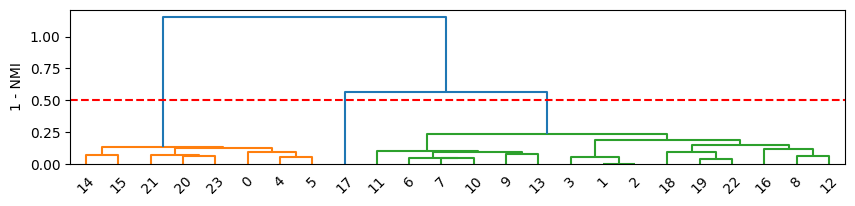

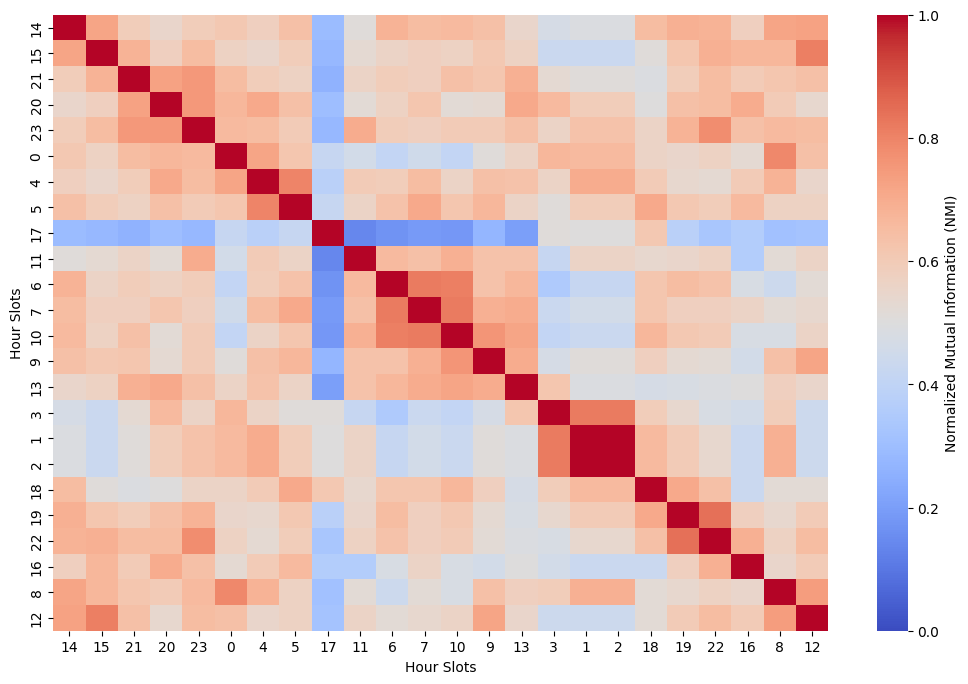

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.cluster.hierarchy as sch
from scipy.spatial.distance import squareform

# Convert NMI DataFrame to a NumPy array
nmi_values = df_NMI.to_numpy()

# Fill the diagonal of the NMI array with 1
np.fill_diagonal(nmi_values, 1)

# Calculate the NMI distance matrix (1 - NMI) to represent dissimilarity
nmi_distance_matrix = 1 - nmi_values
color_threshold = 0.5
num_clusters = list(Results["Number of Communities (Shs & Sts) by FG"])

# Create a distance matrix based on both number of clusters and NMI
n_graphs = len(num_clusters)
combined_distance_matrix = np.zeros((n_graphs, n_graphs))

# Combine both distance measures
for i in range(n_graphs):
    for j in range(n_graphs):
        combined_distance_matrix[i][j] = abs(num_clusters[i] - num_clusters[j]) + nmi_distance_matrix[i][j]


# Step 2: Perform hierarchical clustering
Z = sch.linkage(squareform(combined_distance_matrix/4), method='ward')

# Step 3: Plot the dendrogram with a color threshold
plt.figure(figsize=(10, 2))


# Create the dendrogram
dendro = sch.dendrogram(Z, labels=[f'{i}' for i in range(n_graphs)], color_threshold=color_threshold)

#plt.xlabel("Bipartite Graphs")
plt.ylabel("1 - NMI")
plt.axhline(y=color_threshold, color='r', linestyle='--')  # Draw a horizontal line at the threshold
plt.show()

# Create an ordered heatmap based on the dendrogram
# Get the ordering of the clusters
order = dendro['leaves']


# Reorder the NMI values based on the dendrogram order
ordered_nmi_values = nmi_values[order, :][:, order]

# Step 4: Plot the heatmap
plt.figure(figsize=(12.5, 8))
sns.heatmap(ordered_nmi_values, annot=False, fmt=".2f", cmap='coolwarm',
            xticklabels=[f'{i}' for i in order],
            yticklabels=[f'{i}' for i in order],
            cbar_kws={'label': 'Normalized Mutual Information (NMI)'},
            vmin=0,   # Minimum value of the color scale
            vmax=1    # Maximum value of the color scale
)

#plt.title('Heatmap of NMI Values Ordered by Dendrogram Clustering')
plt.xlabel('Hour Slots')
plt.ylabel('Hour Slots')
plt.show()

# Save combined figure
file_path = '/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/results/Bull_Dendrogram and Heatmap of NMI.png'
plt.savefig(file_path)
plt.close()

In [ ]:
from scipy.cluster.hierarchy import fcluster

# Get cluster assignments for each item
cluster_assignments = fcluster(Z, t=color_threshold, criterion='distance')
color = ['orange', 'green', 'blue', 'red', 'purple']
# Create dictionary mapping cluster ID to list of item indices
NMI_clusters = {}
for idx, cluster_id in enumerate(cluster_assignments):
    NMI_clusters.setdefault(color[cluster_id-1], []).append(idx)

print("Extracted Clusters Dictionary:")
print(NMI_clusters)

Extracted Clusters Dictionary:
{'orange': [0, 4, 5, 14, 15, 20, 21, 23], 'green': [1, 2, 3, 6, 7, 8, 9, 10, 11, 12, 13, 16, 18, 19, 22], 'blue': [17]}


# Communities summary based on NMI clustering

In [46]:
column_names = [
    'Network hour',
    "Network density",
    "Number of edges",
    "Modularity of FG",
    "Number of detected communities by FG",
    "Number of single community by FG"]
Results = pd.DataFrame(index=NMI_clusters.keys(),columns=column_names)
FG = {}

In [47]:
df_shark = df_sharks[['Shark', 'Latitude', 'Longitude']]
df_station = df_stations[['Station', 'Latitude', 'Longitude']]

df_shark.rename(columns={"Shark":"Label"},inplace=True)
df_station.rename(columns={"Station":"Label"},inplace=True)

sharks_stations = pd.concat([df_shark,df_station], ignore_index=True)

In [48]:
cluster = 'blue'
hour_mask = detections['Hour'].isin(NMI_clusters[cluster])
hour_detections = detections[hour_mask]
h_detections = hour_detections.groupby(['Shark','Station']).size().reset_index(name='num_detections')

###################################################################################################################################################################
##############################################  create a bipartite graph #############################################
B = nx.Graph()
# Add shark nodes with positions
for index, row in df_sharks.iterrows():
    B.add_node(row['Shark'], bipartite=0, pos=(row['Longitude'], row['Latitude']))

# Add station nodes with positions
for index, row in df_stations.iterrows():
    B.add_node(row['Station'], bipartite=1, pos=(row['Longitude'], row['Latitude']))

# Add edges and weights
for i, row in h_detections.iterrows():
    B.add_edge(row['Shark'], row['Station'], weight=row['num_detections'])

Results.loc[cluster, 'Network hour'] =  str(cluster)


Results.loc[cluster, 'Network density'] =  round(nx.density(B), 2)
Results.loc[cluster, 'Number of edges'] =  nx.number_of_edges(B)

###################################################################################################################################################################################
########################################################   FastGreedy  ####################################################
# Detect communities using the fast greedy modularity algorithm with the specified weight attribute
c_greedy = list(nx.community.greedy_modularity_communities(B, weight='weight', resolution=0.75))

# Calculate the modularity of the detected communities
modularity = nx.community.modularity(B, c_greedy)
Results.loc[cluster, 'Modularity of FG'] =  round(modularity, 3)
Results.loc[cluster, 'Number of detected communities by FG'] =  len(c_greedy)

c = 0
for i in range(0,len(c_greedy)):
    if len(c_greedy[i]) == 1:
        c += 1
Results.loc[cluster, 'Number of single community by FG'] = c

shk_sts_community = len(c_greedy) - c

#######################################################################################################################################################################################
##################################################    Saving the communities   #########################################################

FG[cluster] = c_greedy
All_methods = { "FastGreedy":c_greedy}
for key, clusters in All_methods.items():
    my_list = clusters


    # Sorting each sublist in descending order
    for j, sublist in enumerate(my_list):
        sublist = list(sublist)
        sublist.sort(key=str)
        my_list[j] = sublist

    my_list.sort(key=lambda x: x[0], reverse = False)

    # Updated list
    All_methods[key] = my_list

df = pd.DataFrame.from_dict(All_methods, orient='index')
df.rename(columns={0: 1, 1: 2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9,
                    9:10, 10:11, 11:12, 11:12, 12:13, 13: 14, 14: 15, 15:16, 16:17, 17:18, 18:19, 19:20}, inplace=True)

dict_communities = df.apply(lambda row: row.iloc[0:].to_dict(), axis=1).to_dict()



n_com = {}
for com, values in dict_communities.items():
    nv = []
    for k,v in values.items():
        nv.append(v)
    n_com[com] = nv
dict_communities = n_com

#######################################################################################################################################################################################
########################## # Number of links # ##################################


name = cluster +'_Number of links'


sha = hour_detections.groupby('Shark')['Station'].nunique().reset_index(name=name)
sta = hour_detections.groupby('Station')['Shark'].nunique().reset_index(name=name)

sha.rename(columns={"Shark":"Label"},inplace=True)
sta.rename(columns={"Station":"Label"},inplace=True)

sha_sta = pd.concat([sha,sta], ignore_index=True)
sharks_stations = pd.merge(sharks_stations, sha_sta, on='Label', how='outer')

########################## # Community & Color # ##################################

if shk_sts_community == 2:
    sharks_stations = assertion_index_color(cluster, sharks_stations, tag_color_index_2, 3, dict_communities)

elif shk_sts_community == 3:
    sharks_stations = assertion_index_color(cluster, sharks_stations, tag_color_index_3_H1, 4, dict_communities)

elif shk_sts_community == 4:
    sharks_stations = assertion_index_color(cluster, sharks_stations, tag_color_index_4_23, 5, dict_communities)


sharks_stations = sharks_stations


name = cluster +'_Number of links'
hr = cluster +'_community'
hrcolor = cluster +'_Color'



indices = sharks_stations[sharks_stations[[name,hr,hrcolor]].isna().all(axis=1)].index

sharks_stations.loc[indices, hrcolor] = "#FFD700"

if shk_sts_community == 2:
  sharks_stations.loc[indices, hr] = 3

elif shk_sts_community == 3:
    sharks_stations.loc[indices, hr] = 4

else:
    sharks_stations.loc[indices, hr] = 5

######################################################################################################################################################################################
##############################################   Drawing the networks #############################################
# Adjusting the map resolution to 'intermediate'
fig, ax = plt.subplots(figsize=(29,20))
m = Basemap(projection='tmerc', lat_0 = df_sharks_stations['Latitude'].mean(), lon_0 = df_sharks_stations['Longitude'].mean(),
            llcrnrlon=166.2700, llcrnrlat=-22.3500,
            urcrnrlon=166.4900, urcrnrlat=-22.2100,  resolution='i', ax=ax)

# Load the orthophoto
image = plt.imread('/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Data/ground.jpg')

image_flipped = np.flipud(image)
m.imshow(image_flipped)



hrcolor = cluster + '_Color'

df_sharks_stations = sharks_stations[['Label', 'Latitude', 'Longitude', hrcolor]]


mx, my = m( df_sharks_stations['Longitude'].values,  df_sharks_stations['Latitude'].values)
pos = {}
for count, elem in enumerate ( df_sharks_stations['Label']):
    pos[elem] = (mx[count], my[count])

### Extract the edge weight
edge_weights = [B[u][v]['weight'] for u, v in B.edges()]
edge_intervals = build_intervals_from_weights(edge_weights)
new_edge_weights = adjust_edge_weights(edge_weights)

#  Calculate node degrees
node_degree = dict(B.degree())




# Draw nodes
for node in df_sharks_stations['Label'] :
    if node in Sharks:
        shape = 'D'
        node_size = [(((1+node_degree[node]-min(shark_degrees))/(max(shark_degrees)-min(shark_degrees))))*3500]
    else:
        shape = 'o'
        node_size = [(((1+node_degree[node]-min(station_degrees))/(max(station_degrees)-min(station_degrees))))*3000]
    nx.draw_networkx_nodes(B, pos, nodelist=[node], node_color=[df_sharks_stations.loc[df_sharks_stations['Label'] == node, hrcolor].values[0]], node_size=node_size, node_shape=shape, edgecolors=['k'])


pos_higher = {}

for k, v in pos.items():
    if(v[1]>0):
        pos_higher[k] = (v[0], v[1])
    else:
        pos_higher[k] = (v[0], v[1])


bbox = dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3')
# Draw networkx labels with vertical alignment adjusted using bbox
for node, (x, y) in pos_higher.items():
    if node in Sharks_labels.keys():
        plt.text(x, y, Sharks_labels[node], fontsize=25*((1+node_degree[node]-min(shark_degrees))/(max(shark_degrees)-min(shark_degrees))), color='k', ha='center', va='center',  )
    else:

        plt.text(x, y, Stations_labels[node], fontsize=25*((1+node_degree[node]-min(station_degrees))/(max(station_degrees)-min(station_degrees))), color='k', ha='center', va='center', )



# Draw edges with width based on the degree
nx.draw_networkx_edges(B, pos, width=new_edge_weights, edge_color='k')


name = cluster

plt.text(0.03, 0.97, f'{NMI_clusters[cluster]} Hours cluster', transform=ax.transAxes,
          fontsize=55, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))

# Edge weight legend
edge_legend_widths = [w for i, w in enumerate(set(new_edge_weights))]
edge_legend_intervals = edge_intervals[:len(edge_legend_widths)]  # Match order
draw_edge_weight_legend(fig, edge_legend_intervals, edge_legend_widths, base_y=0.86, start_x=0.03)

plt.tight_layout()
# Save the plot as a JPG file
name = '/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/results/Bull_' + name +'_Communities.png'
plt.savefig(name)
plt.show()
plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [49]:
cluster = 'green'
hour_mask = detections['Hour'].isin(NMI_clusters[cluster])
hour_detections = detections[hour_mask]
h_detections = hour_detections.groupby(['Shark','Station']).size().reset_index(name='num_detections')

###################################################################################################################################################################
##############################################  create a bipartite graph #############################################
B = nx.Graph()
# Add shark nodes with positions
for index, row in df_sharks.iterrows():
    B.add_node(row['Shark'], bipartite=0, pos=(row['Longitude'], row['Latitude']))

# Add station nodes with positions
for index, row in df_stations.iterrows():
    B.add_node(row['Station'], bipartite=1, pos=(row['Longitude'], row['Latitude']))

# Add edges and weights
for i, row in h_detections.iterrows():
    B.add_edge(row['Shark'], row['Station'], weight=row['num_detections'])

Results.loc[cluster, 'Network hour'] =  str(cluster)


Results.loc[cluster, 'Network density'] =  round(nx.density(B), 2)
Results.loc[cluster, 'Number of edges'] =  nx.number_of_edges(B)

###################################################################################################################################################################################
########################################################   FastGreedy  ####################################################
# Detect communities using the fast greedy modularity algorithm with the specified weight attribute
c_greedy = list(nx.community.greedy_modularity_communities(B, weight='weight', resolution=0.75))

# Calculate the modularity of the detected communities
modularity = nx.community.modularity(B, c_greedy)
Results.loc[cluster, 'Modularity of FG'] =  round(modularity, 3)
Results.loc[cluster, 'Number of detected communities by FG'] =  len(c_greedy)

c = 0
for i in range(0,len(c_greedy)):
    if len(c_greedy[i]) == 1:
        c += 1
Results.loc[cluster, 'Number of single community by FG'] = c

shk_sts_community = len(c_greedy) - c

#######################################################################################################################################################################################
##################################################    Saving the communities   #########################################################

FG[cluster] = c_greedy
All_methods = { "FastGreedy":c_greedy}
for key, clusters in All_methods.items():
    my_list = clusters


    # Sorting each sublist in descending order
    for j, sublist in enumerate(my_list):
        sublist = list(sublist)
        sublist.sort(key=str)
        my_list[j] = sublist

    my_list.sort(key=lambda x: x[0], reverse = False)

    # Updated list
    All_methods[key] = my_list

df = pd.DataFrame.from_dict(All_methods, orient='index')
df.rename(columns={0: 1, 1: 2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9,
                    9:10, 10:11, 11:12, 11:12, 12:13, 13: 14, 14: 15, 15:16, 16:17, 17:18, 18:19, 19:20}, inplace=True)

dict_communities = df.apply(lambda row: row.iloc[0:].to_dict(), axis=1).to_dict()



n_com = {}
for com, values in dict_communities.items():
    nv = []
    for k,v in values.items():
        nv.append(v)
    n_com[com] = nv
dict_communities = n_com

#######################################################################################################################################################################################
########################## # Number of links # ##################################


name = cluster +'_Number of links'


sha = hour_detections.groupby('Shark')['Station'].nunique().reset_index(name=name)
sta = hour_detections.groupby('Station')['Shark'].nunique().reset_index(name=name)

sha.rename(columns={"Shark":"Label"},inplace=True)
sta.rename(columns={"Station":"Label"},inplace=True)

sha_sta = pd.concat([sha,sta], ignore_index=True)
sharks_stations = pd.merge(sharks_stations, sha_sta, on='Label', how='outer')

########################## # Community & Color # ##################################

if shk_sts_community == 2:
    sharks_stations = assertion_index_color(cluster, sharks_stations, tag_color_index_2, 3, dict_communities)

elif shk_sts_community == 3:
    sharks_stations = assertion_index_color(cluster, sharks_stations, tag_color_index_3_H1, 4, dict_communities)

elif shk_sts_community == 4:
    sharks_stations = assertion_index_color(cluster, sharks_stations, tag_color_index_4_23, 5, dict_communities)


sharks_stations = sharks_stations


name = cluster +'_Number of links'
hr = cluster +'_community'
hrcolor = cluster +'_Color'



indices = sharks_stations[sharks_stations[[name,hr,hrcolor]].isna().all(axis=1)].index

sharks_stations.loc[indices, hrcolor] = "#FFD700"

if shk_sts_community == 2:
  sharks_stations.loc[indices, hr] = 3

elif shk_sts_community == 3:
    sharks_stations.loc[indices, hr] = 4

else:
    sharks_stations.loc[indices, hr] = 5

######################################################################################################################################################################################
##############################################   Drawing the networks #############################################
# Adjusting the map resolution to 'intermediate'
fig, ax = plt.subplots(figsize=(29,20))
m = Basemap(projection='tmerc', lat_0 = df_sharks_stations['Latitude'].mean(), lon_0 = df_sharks_stations['Longitude'].mean(),
            llcrnrlon=166.2700, llcrnrlat=-22.3500,
            urcrnrlon=166.4900, urcrnrlat=-22.2100,  resolution='i', ax=ax)

# Load the orthophoto
image = plt.imread('/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Data/ground.jpg')

image_flipped = np.flipud(image)
m.imshow(image_flipped)



hrcolor = cluster + '_Color'

df_sharks_stations = sharks_stations[['Label', 'Latitude', 'Longitude', hrcolor]]


mx, my = m( df_sharks_stations['Longitude'].values,  df_sharks_stations['Latitude'].values)
pos = {}
for count, elem in enumerate ( df_sharks_stations['Label']):
    pos[elem] = (mx[count], my[count])

### Extract the edge weight
edge_weights = [B[u][v]['weight'] for u, v in B.edges()]
edge_intervals = build_intervals_from_weights(edge_weights)
new_edge_weights = adjust_edge_weights(edge_weights)

#  Calculate node degrees
node_degree = dict(B.degree())


# Draw nodes
for node in df_sharks_stations['Label'] :
    if node in Sharks:
        shape = 'D'
        node_size = [(((1+node_degree[node]-min(shark_degrees))/(max(shark_degrees)-min(shark_degrees))))*3500]
    else:
        shape = 'o'
        node_size = [(((1+node_degree[node]-min(station_degrees))/(max(station_degrees)-min(station_degrees))))*3000]
    nx.draw_networkx_nodes(B, pos, nodelist=[node], node_color=[df_sharks_stations.loc[df_sharks_stations['Label'] == node, hrcolor].values[0]], node_size=node_size, node_shape=shape, edgecolors=['k'])


pos_higher = {}

for k, v in pos.items():
    if(v[1]>0):
        pos_higher[k] = (v[0], v[1])
    else:
        pos_higher[k] = (v[0], v[1])


bbox = dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3')
# Draw networkx labels with vertical alignment adjusted using bbox
for node, (x, y) in pos_higher.items():
    if node in Sharks_labels.keys():
        plt.text(x, y, Sharks_labels[node], fontsize=25*((1+node_degree[node]-min(shark_degrees))/(max(shark_degrees)-min(shark_degrees))), color='k', ha='center', va='center',  )
    else:

        plt.text(x, y, Stations_labels[node], fontsize=25*((1+node_degree[node]-min(station_degrees))/(max(station_degrees)-min(station_degrees))), color='k', ha='center', va='center', )



# Draw edges with width based on the degree
nx.draw_networkx_edges(B, pos, width=new_edge_weights, edge_color='k')

name = cluster

plt.text(0.03, 0.97, f'{NMI_clusters[cluster]} Hours cluster', transform=ax.transAxes,
          fontsize=50, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))

# Edge weight legend
edge_legend_widths = [w for i, w in enumerate(set(new_edge_weights))]
edge_legend_intervals = edge_intervals[:len(edge_legend_widths)]  # Match order
draw_edge_weight_legend(fig, edge_legend_intervals, edge_legend_widths, base_y=0.86, start_x=0.03)

plt.tight_layout()
# Save the plot as a JPG file
name = '/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/results/Bull_' + name +'_Communities.png'
plt.savefig(name)
plt.show()
plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [50]:
cluster = 'orange'
hour_mask = detections['Hour'].isin(NMI_clusters[cluster])
hour_detections = detections[hour_mask]
h_detections = hour_detections.groupby(['Shark','Station']).size().reset_index(name='num_detections')

###################################################################################################################################################################
##############################################  create a bipartite graph #############################################
B = nx.Graph()
# Add shark nodes with positions
for index, row in df_sharks.iterrows():
    B.add_node(row['Shark'], bipartite=0, pos=(row['Longitude'], row['Latitude']))

# Add station nodes with positions
for index, row in df_stations.iterrows():
    B.add_node(row['Station'], bipartite=1, pos=(row['Longitude'], row['Latitude']))

# Add edges and weights
for i, row in h_detections.iterrows():
    B.add_edge(row['Shark'], row['Station'], weight=row['num_detections'])

Results.loc[cluster, 'Network hour'] =  str(cluster)


Results.loc[cluster, 'Network density'] =  round(nx.density(B), 2)
Results.loc[cluster, 'Number of edges'] =  nx.number_of_edges(B)

###################################################################################################################################################################################
########################################################   FastGreedy  ####################################################
# Detect communities using the fast greedy modularity algorithm with the specified weight attribute
c_greedy = list(nx.community.greedy_modularity_communities(B, weight='weight', resolution=1))

# Calculate the modularity of the detected communities
modularity = nx.community.modularity(B, c_greedy)
Results.loc[cluster, 'Modularity of FG'] =  round(modularity, 3)
Results.loc[cluster, 'Number of detected communities by FG'] =  len(c_greedy)

c = 0
for i in range(0,len(c_greedy)):
    if len(c_greedy[i]) == 1:
        c += 1
Results.loc[cluster, 'Number of single community by FG'] = c

shk_sts_community = len(c_greedy) - c

#######################################################################################################################################################################################
##################################################    Saving the communities   #########################################################

FG[cluster] = c_greedy
All_methods = { "FastGreedy":c_greedy}
for key, clusters in All_methods.items():
    my_list = clusters


    # Sorting each sublist in descending order
    for j, sublist in enumerate(my_list):
        sublist = list(sublist)
        sublist.sort(key=str)
        my_list[j] = sublist

    my_list.sort(key=lambda x: x[0], reverse = False)

    # Updated list
    All_methods[key] = my_list

df = pd.DataFrame.from_dict(All_methods, orient='index')
df.rename(columns={0: 1, 1: 2, 2:3, 3:4, 4:5, 5:6, 6:7, 7:8, 8:9,
                    9:10, 10:11, 11:12, 11:12, 12:13, 13: 14, 14: 15, 15:16, 16:17, 17:18, 18:19, 19:20}, inplace=True)

dict_communities = df.apply(lambda row: row.iloc[0:].to_dict(), axis=1).to_dict()



n_com = {}
for com, values in dict_communities.items():
    nv = []
    for k,v in values.items():
        nv.append(v)
    n_com[com] = nv
dict_communities = n_com

#######################################################################################################################################################################################
########################## # Number of links # ##################################


name = cluster +'_Number of links'


sha = hour_detections.groupby('Shark')['Station'].nunique().reset_index(name=name)
sta = hour_detections.groupby('Station')['Shark'].nunique().reset_index(name=name)

sha.rename(columns={"Shark":"Label"},inplace=True)
sta.rename(columns={"Station":"Label"},inplace=True)

sha_sta = pd.concat([sha,sta], ignore_index=True)
sharks_stations = pd.merge(sharks_stations, sha_sta, on='Label', how='outer')

########################## # Community & Color # ##################################

if shk_sts_community == 2:
    sharks_stations = assertion_index_color(cluster, sharks_stations, tag_color_index_2, 3, dict_communities)

elif shk_sts_community == 3:
    sharks_stations = assertion_index_color(cluster, sharks_stations, tag_color_index_3_H1, 4, dict_communities)

elif shk_sts_community == 4:
    sharks_stations = assertion_index_color(cluster, sharks_stations, tag_color_index_4_23, 5, dict_communities)


sharks_stations = sharks_stations


name = cluster +'_Number of links'
hr = cluster +'_community'
hrcolor = cluster +'_Color'



indices = sharks_stations[sharks_stations[[name,hr,hrcolor]].isna().all(axis=1)].index

sharks_stations.loc[indices, hrcolor] = "#FFD700"

if shk_sts_community == 2:
  sharks_stations.loc[indices, hr] = 3

elif shk_sts_community == 3:
    sharks_stations.loc[indices, hr] = 4

else:
    sharks_stations.loc[indices, hr] = 5

######################################################################################################################################################################################
##############################################   Drawing the networks #############################################
# Adjusting the map resolution to 'intermediate'
fig, ax = plt.subplots(figsize=(29,20))
m = Basemap(projection='tmerc', lat_0 = df_sharks_stations['Latitude'].mean(), lon_0 = df_sharks_stations['Longitude'].mean(),
            llcrnrlon=166.2700, llcrnrlat=-22.3500,
            urcrnrlon=166.4900, urcrnrlat=-22.2100,  resolution='i', ax=ax)

# Load the orthophoto
image = plt.imread('/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/Data/ground.jpg')

image_flipped = np.flipud(image)
m.imshow(image_flipped)



hrcolor = cluster + '_Color'

df_sharks_stations = sharks_stations[['Label', 'Latitude', 'Longitude', hrcolor]]


mx, my = m( df_sharks_stations['Longitude'].values,  df_sharks_stations['Latitude'].values)
pos = {}
for count, elem in enumerate ( df_sharks_stations['Label']):
    pos[elem] = (mx[count], my[count])

### Extract the edge weight
edge_weights = [B[u][v]['weight'] for u, v in B.edges()]
edge_intervals = build_intervals_from_weights(edge_weights)
new_edge_weights = adjust_edge_weights(edge_weights)

#  Calculate node degrees
node_degree = dict(B.degree())



# Draw nodes
for node in df_sharks_stations['Label'] :
    if node in Sharks:
        shape = 'D'
        node_size = [(((1+node_degree[node]-min(shark_degrees))/(max(shark_degrees)-min(shark_degrees))))*3500]
    else:
        shape = 'o'
        node_size = [(((1+node_degree[node]-min(station_degrees))/(max(station_degrees)-min(station_degrees))))*3000]
    nx.draw_networkx_nodes(B, pos, nodelist=[node], node_color=[df_sharks_stations.loc[df_sharks_stations['Label'] == node, hrcolor].values[0]], node_size=node_size, node_shape=shape, edgecolors=['k'])


pos_higher = {}

for k, v in pos.items():
    if(v[1]>0):
        pos_higher[k] = (v[0], v[1])
    else:
        pos_higher[k] = (v[0], v[1])


bbox = dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3')
# Draw networkx labels with vertical alignment adjusted using bbox
for node, (x, y) in pos_higher.items():
    if node in Sharks_labels.keys():
        plt.text(x, y, Sharks_labels[node], fontsize=25*((1+node_degree[node]-min(shark_degrees))/(max(shark_degrees)-min(shark_degrees))), color='k', ha='center', va='center',  )
    else:

        plt.text(x, y, Stations_labels[node], fontsize=25*((1+node_degree[node]-min(station_degrees))/(max(station_degrees)-min(station_degrees))), color='k', ha='center', va='center', )


# Draw edges with width based on the degree
nx.draw_networkx_edges(B, pos, width=new_edge_weights, edge_color='k')


name = cluster

plt.text(0.03, 0.97, f'{NMI_clusters[cluster]} Hours cluster', transform=ax.transAxes,
          fontsize=55, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5, edgecolor='black', boxstyle='round,pad=0.3'))

# Edge weight legend
edge_legend_widths = [w for i, w in enumerate(set(new_edge_weights))]
edge_legend_intervals = edge_intervals[:len(edge_legend_widths)]  # Match order
draw_edge_weight_legend(fig, edge_legend_intervals, edge_legend_widths, base_y=0.86, start_x=0.03)

plt.tight_layout()
# Save the plot as a JPG file
name = '/content/drive/Othercomputers/My Laptop/24HourlyBipartitGraphs/results/Bull_' + name +'_Communities.png'
plt.savefig(name)
plt.show()
plt.close()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
sharks_stations

,Label,Latitude,Longitude,blue_Number of links,blue_community,blue_Color,green_Number of links,green_community,green_Color,orange_Number of links,orange_community,orange_Color
0,B01F,-22.275800,166.393900,7,2,#AB63FA,23,3,#19D3F3,20,3,#19D3F3
1,B02F,-22.291900,166.418200,13,2,#AB63FA,40,3,#19D3F3,43,3,#19D3F3
2,B03F,-22.301200,166.416500,35,2,#AB63FA,41,3,#19D3F3,41,3,#19D3F3
3,B04F,-22.300000,166.391600,39,2,#AB63FA,44,3,#19D3F3,44,3,#19D3F3
4,B05F,-22.316300,166.373400,5,2,#AB63FA,28,3,#19D3F3,18,3,#19D3F3
...,...,...,...,...,...,...,...,...,...,...,...,...
58,V5,-22.304504,166.438775,4,2,#AB63FA,12,1,#00CC96,9,1,#00CC96
59,V6,-22.304216,166.441574,5,2,#AB63FA,12,1,#00CC96,8,1,#00CC96
60,V7,-22.304696,166.444529,5,2,#AB63FA,11,1,#00CC96,8,4,#A65628
61,V8,-22.306791,166.446169,6,2,#AB63FA,10,1,#00CC96,8,4,#A65628


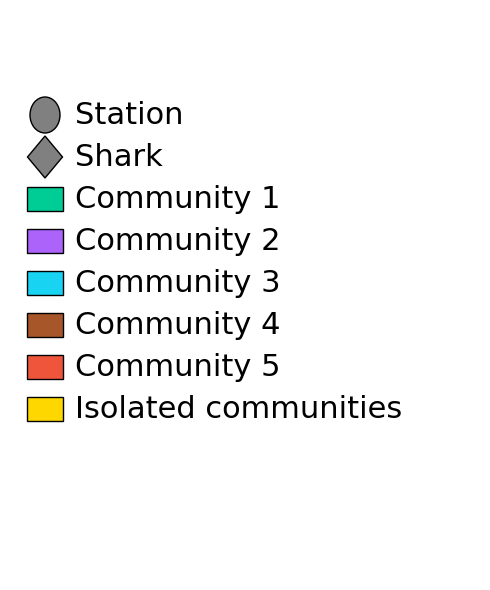

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon, Rectangle

def draw_separated_legend(ax, start_x=0.1, start_y=0.8, spacing_y=0.07):
    trans = ax.figure.transFigure

    # Row 1: Station (circle)
    circle = Ellipse((start_x, start_y), width=0.06, height=0.06,
                     color='gray', ec='black', transform=trans, clip_on=False)
    ax.figure.add_artist(circle)
    ax.figure.text(start_x + 0.06, start_y, "Station", fontsize=22, ha='left', va='center', transform=trans)

    # Row 2: Shark (diamond)
    diamond_size = 0.035
    y2 = start_y - spacing_y
    diamond_points = [
        (start_x, y2 + diamond_size),
        (start_x + diamond_size, y2),
        (start_x, y2 - diamond_size),
        (start_x - diamond_size, y2)
    ]
    diamond = Polygon(diamond_points, closed=True, color='gray', ec='black',
                      transform=trans, clip_on=False)
    ax.figure.add_artist(diamond)
    ax.figure.text(start_x + 0.06, y2, "Shark", fontsize=22, ha='left', va='center', transform=trans)

    # Community colors
    community_colors = {
        '#00CC96': 'Community 1',
        '#AB63FA': 'Community 2',
        '#19D3F3': 'Community 3',
        '#A65628': 'Community 4',
        '#EF553B': 'Community 5',
        '#FFD700': 'Isolated communities'
    }

    for i, (color, label) in enumerate(community_colors.items()):
        y = y2 - ((i + 1) * spacing_y)
        block = Rectangle((start_x - 0.035, y - 0.02), width=0.07, height=0.04,
                          color=color, ec='black', transform=trans, clip_on=False)
        ax.figure.add_artist(block)
        ax.figure.text(start_x + 0.06, y, label, fontsize=22, ha='left', va='center', transform=trans)

# === Create and Save the Figure ===
fig, ax = plt.subplots(figsize=(5, 6))
ax.axis('off')
draw_separated_legend(ax)
plt.tight_layout()
plt.savefig("separated_legend.png", dpi=300)
plt.show()
